In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer

# Triangulacja wielokątów monotonicznych - problem monitorowania galerii


## Przydatne funkcje


In [2]:
polygon_example_1 = [(5, 5), (3, 4), (6, 3), (4, 2), (6, 0), (7, 1), (8, 4)]
polygon_example_2 = [(2, 0), (5, 1), (6, 0), (8, 3), (7, 2), (8, 7), (6, 9), (5, 8),
                     (2, 9), (1, 7), (2, 4), (4, 5), (3, 6), (5, 7), (5.5, 3), (2, 2), (1, 3), (0, 1)]
polygon_example_colors = [1, 3, 1, 0, 2, 4, 0, 2, 0, 4, 1, 4, 4, 3, 4, 2, 0, 4]
polygon_example_tri = [(polygon_example_1[0], polygon_example_1[2]),
                       (polygon_example_1[2], polygon_example_1[5]),
                       (polygon_example_1[2], polygon_example_1[6]),
                       #   (polygon_example_1[6], polygon_example_1[3]),
                       (polygon_example_1[2], polygon_example_1[4]),
                       ]

In [3]:
def draw_polygon(polygon):
    vis = Visualizer()
    points = polygon
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [4]:
def draw_polygon_colors(polygon, colors):
    points_start = []
    points_end = []
    points_connect = []
    points_divide = []
    points_regular = []
    for i in range(len(polygon)):
        if colors[i] == 0:
            points_start.append(polygon[i])
        elif colors[i] == 1:
            points_end.append(polygon[i])
        elif colors[i] == 2:
            points_connect.append(polygon[i])
        elif colors[i] == 3:
            points_divide.append(polygon[i])
        elif colors[i] == 4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end = ['red']
    color_connect = ['blue']
    color_divide = ['cyan']
    color_regular = ['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [5]:
def draw_polygon_tri(polygon, tri):

    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

## Wprowadzenie
Celem ćwiczenia jest:
- sprawdzanie $y$-monotoniczności
- podział wierchołków na kategorie
- triangulacja wielokąta monotonicznego

### Przykładowy wielokąt $y$-monotoniczny

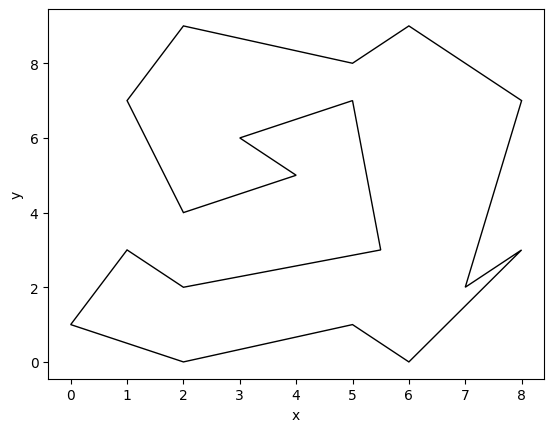

In [6]:
draw_polygon(polygon_example_2)

Do tego celu wygeneruj wielokąt.

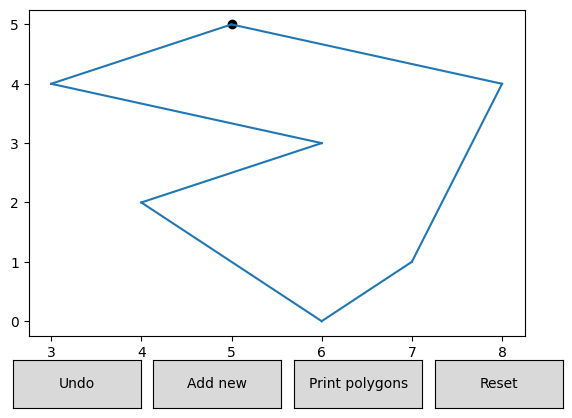

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from math import inf


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


TOLERANCE = 0.01


def create_buttons(callback):
    button_y = 0.05
    button_width = 0.2
    button_height = 0.1
    button_n = 3
    button_pos = [[1-(i+1.5)*button_width, button_y, button_width,
                   button_height] for i in range(button_n)]
    # axprev = fig.add_axes([0.7, button_y, button_width, button_height])
    # axnext = fig.add_axes([0.01, 0.05, 0.1, 0.175])  # lewo gora szerokosc wysokosc
    axes = [callback.fig.add_axes(pos) for pos in button_pos]
    bnext = Button(axes[0], 'Reset')
    bnext.on_clicked(callback.reset)
    bprev = Button(axes[1], 'Print polygons')
    bprev.on_clicked(callback.print_polygons)
    btest = Button(axes[2], 'Add new')
    btest.on_clicked(callback.add_new_polygon)


class myPlot:
    def __init__(self, polygon=None) -> None:
        fig, ax = plt.subplots()
        fig.subplots_adjust(bottom=0.2)
        fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.fig = fig
        # ax = plt.axes(autoscale_on=False)
        self.ax = ax
        self.points = []
        self.lines = []
        self.polygons = []
        self.autoscaling = False
        if polygon is not None:
            self.load_polygon(polygon)

        self.closed = False
        # self.create_buttons()

    def load_polygon(self, polygon):
        self.polygons.append(polygon)
        for i in range(len(polygon)):
            p1 = polygon[i]
            p2 = polygon[(i+1) % len(polygon)]
            self.add_line(plt.Line2D([p1[0], p2[0]], [p1[1], p2[1]]))
            self.add_point(p2)
        self.closed = True
        self.autoscaling = True
        self.draw()

    def reset(self, event):
        self.add_new_polygon(event)
        self.polygons = []
        self.draw()

    def print_polygons(self, event):
        if len(self.polygons) == 0:
            print("Nie ma zapisanych wielokątów")

        for polygon in self.polygons:
            print(polygon)

    def add_new_polygon(self, event):
        self.points = []
        self.lines = []
        self.closed = False
        self.autoscaling = False
        self.draw()

    def undo(self, event):
        if len(self.points) > 0:
            self.points.pop()
        if len(self.lines) > 0:
            self.lines.pop()
        if self.closed:
            self.closed = False
            if len(self.polygons) > 0:
                self.polygons.pop()

        self.draw()

    def add_point(self, point):
        self.points.append(point)

    def add_line(self, line):
        self.lines.append(line)

    def close_polygon(self, event):
        x = event.xdata
        y = event.ydata
        for point in self.points:
            if dist(point, [x, y]) < TOLERANCE:
                self.closed = True
                return point
        return x, y

    def save_polygon(self):
        lines = self.lines
        polygon = []
        for line in lines:
            polygon.append(
                np.array([line.get_xdata()[0], line.get_ydata()[0]]))

        self.polygons.append(polygon)
        print(polygon)

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        x, y = self.close_polygon(event)
        if len(self.points) == 0 or self.closed:
            self.add_point([x, y])
        else:
            p1 = self.points[-1]
            p2 = [x, y]
            # Create a line using x and y coordinates
            self.add_line(plt.Line2D([p1[0], p2[0]], [p1[1], p2[1]]))
            self.add_point(p2)
        if self.closed:
            self.save_polygon()
        self.draw()

    def draw(self):
        xlim = self.ax.get_xlim()
        ylim = self.ax.get_ylim()
        self.ax.clear()
        if len(self.points) > 0:
            point = self.points[-1]
            self.ax.scatter(point[0], point[1], color='black')
        for line in self.lines:
            self.ax.add_line(line)
        self.ax.autoscale(self.autoscaling)
        if not self.autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

    def show(self):
        plt.show()


polygon_example_1 = [(5, 5), (3, 4), (6, 3), (4, 2), (6, 0), (7, 1), (8, 4)]
myplot = myPlot(polygon_example_1)
fig = myplot.fig


# # create buttons
button_y = 0.05
button_width = 0.2
button_height = 0.1
button_n = 4
button_pos = [[i*button_width*1.1+0.1, button_y, button_width,
               button_height] for i in range(button_n)]
axes = [fig.add_axes(pos) for pos in button_pos]
bundo = Button(axes[0], 'Undo')
bundo.on_clicked(myplot.undo)
bnew = Button(axes[1], 'Add new')
bnew.on_clicked(myplot.add_new_polygon)
bprint = Button(axes[2], 'Print polygons')
bprint.on_clicked(myplot.print_polygons)
breset = Button(axes[3], 'Reset')
breset.on_clicked(myplot.reset)

myplot.show()

In [8]:
polygon = [(2, 0), (2, 2), (0.75, 2), (1.25, 1.5), (0.5, 1), (1, 0.5), (0, 0)]

## Czy wielokąt jest $y$-monotoniczny?

Wielokąt jest monotoniczny, gdy jego wierzchołki mogą być ułożone w taki sposób, że jedna z jego współrzędnych (na przykład współrzędna $x$ lub $y$, w zależności od układu współrzędnych) zawsze rośnie lub maleje wzdłuż kolejnych wierzchołków. Innymi słowy, dla każdej pary wierzchołków wielokąta (oprócz wierzchołka startowego i końcowego), jeden z punktów ma większą (lub mniejszą) wartość danej współrzędnej niż drugi punkt.

W praktyce, wielokąt monotoniczny może być łatwiej sortowany lub przetwarzany w pewnych algorytmach geometrycznych, ponieważ istnieje pewna kolejność, w jakiej wierzchołki pojawiają się wzdłuż danej osi (np. osi $x$ lub $y$). Monotoniczność może ułatwić znajdowanie przecięć linii w takim wielokącie lub wykonywanie innych operacji geometrycznych. W tym zadaniu interesuje nas monotoniczność wielokąta wzdłuż osi $y$.

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```is_y_monotonic```. Pamiętaj, aby sprawozdanie zawierało krótki opis działania tej funkcji.

In [9]:
def find_index_of_highest(points, reversed=False, eps=0):
    p0_idx = 0
    p0 = points[0]
    def compare(x, y): return x > y if reversed else x < y
    for i in range(1, len(points)):
        if compare(p0[1], points[i][1]) or (abs(p0[1] - points[i][1]) <= eps and p0[0] > points[i][0]):
            p0 = points[i]
            p0_idx = i
    return p0_idx

In [10]:
def prevNbour(i, n): return i-1 if i > 0 else n-1

In [11]:
def nextNbour(i, n): return (i+1) % n

In [12]:
def is_y_monotonic(polygon):
    """
    Funkcja określa czy podana figura jest y-monotoniczna.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    n = len(polygon)

    if n < 4:
        return True
    pTop = find_index_of_highest(polygon)
    pBottom = find_index_of_highest(polygon, reversed=True)
    i = nextNbour(pTop, n)
    prev_y = polygon[pTop][1]
    while i != pBottom:
        curr_y = polygon[i][1]
        if curr_y > prev_y:
            return False
        prev_y = curr_y
        i = nextNbour(i, n)

    i = prevNbour(pTop, n)
    prev_y = polygon[pTop][1]
    while i != pBottom:
        curr_y = polygon[i][1]
        if curr_y > prev_y:
            return False
        prev_y = curr_y
        i = prevNbour(i, n)

    return True

Przeprowadź test poprawności powyższej funkcji.

In [13]:
Test().runtest(1, is_y_monotonic)

Lab 3, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.004s


Sprawdź monotoniczność swojego wielokątu.

In [14]:
print(is_y_monotonic(polygon))

True


***

# Podział wierzchołków na kategorie

Wierzchołki naszego wielokąta możemy podzielić na parę kategorii:
- początkowe, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których wielokąt zaczyna się monotoniczny spadek 
- końcowe, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których monotoniczność wielokąta się zmienia, czyli na przykład zaczyna się monotoniczny wzrost, jeśli wcześniej był spadek, lub na odwrót.

Wierzchołki startowe i końcowe są ważne w kontekście algorytmów przetwarzania wielokątów monotonicznych, takich jak algorytmy dziel i zwyciężaj oraz triangulacji. 
- dzielący, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które wyznaczają przekątne (linie łączące), tworzące trójkąty podczas triangulacji.
- łączący, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które są połączone liniami (przekątnymi) wewnątrz wielokąta, tworząc trójkąty.

Wierzchołki łączące i dzielące odgrywają kluczową rolę w procesie triangulacji wielokątów, pozwalając na podział figury na trójkąty w sposób bezkolizyjny. 
- prawdiłowy, pozostałe przypadki, jeden sąsiad powyżej drugi poniżej


### Przykładowy wielokąt z pokolorowanymi wierzchołkami.

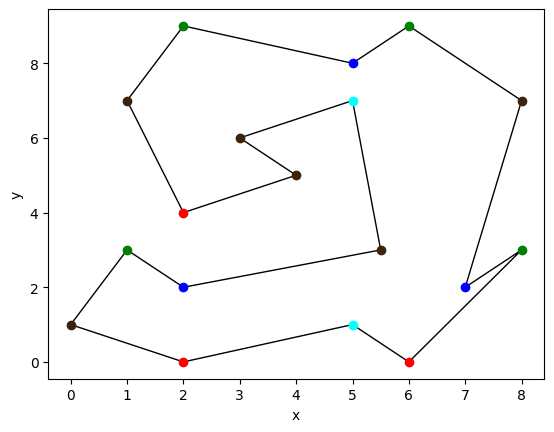

In [15]:
draw_polygon_colors(polygon_example_2, polygon_example_colors)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```color_vertex``` .

In [16]:
def mat_det(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    return (bx-ax)*(cy-by)-(by-ay)*(cx-bx)

In [17]:
# Labels consts
START = "start"
END = "end"
CONNECT = "connect"
DIVIDE = "divide"
REGULAR = "regular"
COLORS_LABELS = {START: 0, END: 1, CONNECT: 2, DIVIDE: 3, REGULAR: 4}

In [18]:
def color_vertex(polygon, colors=COLORS_LABELS):
    """

    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy, 2 - łączący, 3 - dzielący, 4 - prawdiłowy
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """
    n = len(polygon)
    categorized = [0 for _ in range(n)]
    pointsSortedByY = [i for i in range(n)]
    pointsSortedByY = sorted(
        pointsSortedByY, key=lambda x: (-polygon[x][1], polygon[x][0]))
    for p in pointsSortedByY:
        leftP = polygon[nextNbour(p, n)]
        midP = polygon[p]
        rightP = polygon[prevNbour(p, n)]
        if midP[1] > max(leftP[1], rightP[1]):
            # starting - rightP -> midP -> leftP turns to the left => det(left,p,right) > 0
            if mat_det(rightP, midP, leftP) > 0:
                categorized[p] = colors["start"]
            # dividing
            else:
                categorized[p] = colors["divide"]
        elif midP[1] < min(leftP[1], rightP[1]):
            # ending - rightP -> midP -> leftP turns to the left => det(left,p,right) > 0
            if mat_det(rightP, midP, leftP) > 0:
                categorized[p] = colors["end"]
            # connect
            else:
                categorized[p] = colors["connect"]
        else:
            categorized[p] = colors["regular"]
    return categorized

Przeprowadź test poprawności powyższej funkcji. 

In [19]:
Test().runtest(2, color_vertex)

Lab 3, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.004s


Zwizualizuj swój wielokąt z pokolorowanymi według kategorii wierzchołkami.

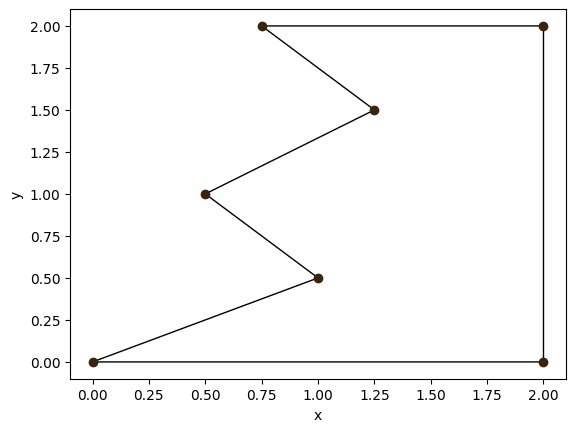

In [20]:
colors = color_vertex(polygon)
draw_polygon_colors(polygon, colors)

***

# Triangulacja wielokąta monotonicznego

Triangulacja wielokąta monotonicznego to proces podziału wielokąta monotonicznego na trójkąty poprzez dodawanie przekątnych (linii łączących wierzchołki), które nie przecinają się wewnętrznie.

### Przykładowy wielokąt podzielony na trójkąty.

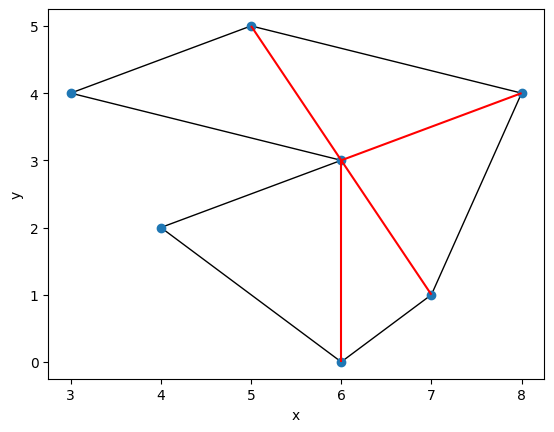

In [21]:
draw_polygon_tri(polygon_example_1, polygon_example_tri)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```triangulation```. Wykorzystaj algorytm opisany na wykładzie.

In [22]:
def onLeftSideOfPolygon(polygon):
    n = len(polygon)
    result = [False for _ in range(n)]
    p = find_index_of_highest(polygon)
    result[p] = True
    p = nextNbour(p, n)
    last = find_index_of_highest(polygon, reversed=True)
    result[last] = True
    while p != last:
        result[p] = True
        p = nextNbour(p, n)

    return result

In [23]:
import bisect
import operator
from collections import namedtuple


class Edge:
    def __init__(self, a, b, helperIdx=None) -> None:
        self.diag = sorted([a, b])
        self.helperIdx = helperIdx
        self.__orderKey = self.firstToRight(0)

    def firstToRight(self, key=0):
        func = min if key == 0 else max
        return self.__closestCoordinate(func, key)

    def firstToLeft(self, key=0):
        func = max if key == 0 else min
        return self.__closestCoordinate(func, key)

    def __closestCoordinate(self, func, key):
        return func(self.diag, key=lambda x: x[key])[key]

    def __eq__(self, other) -> bool:
        return type(self) == type(other) and self.diag == other.diag

    def __lt__(self, other):
        return self.__orderKey < other.__orderKey

    def __gt__(self, other):
        return self.__orderKey > other.__orderKey


class TriBST:

    def __init__(self, polygon, pointsColors, LABELS_COLORS=dict((v, k) for (k, v) in COLORS_LABELS.items())) -> None:
        self.tree = []
        self.polygon = polygon
        self.pointsColors = pointsColors
        self.labels = LABELS_COLORS

    def insertEdge(self, edge: Edge):
        bisect.insort(self.tree, edge)

    def getEdgeHelper(self, edge: Edge):
        if edge.helperIdx is not None:
            return edge.helperIdx
        edgeInState = self.__findEdge(edge)
        if edgeInState != None:
            return edgeInState.helperIdx

    def removeEdge(self, edge):
        i = self.__findEdgeIdx(edge)
        if i != None:
            self.tree.pop(i)
    EdgeQuery = namedtuple("EdgeQuery", ["func", "operator", "coordinate"])

    def createLeftEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(min, operator.le, 0), helper_idx=helper_idx)

    def createRightEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(max, operator.ge, 0), helper_idx=helper_idx)

    def createHigherEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(max, operator.ge, 1), helper_idx=helper_idx)

    def createLowerEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(min, operator.le, 1), helper_idx=helper_idx)

    def __createEdge(self, point_idx, params: EdgeQuery, helper_idx=None):
        polygon = self.polygon
        n = len(polygon)
        coordinate = params.coordinate
        secondCoordinate = 1-coordinate
        relate = params.operator
        func = params.func
        help_func = max if func.__name__ == "min" else min
        candidates = [polygon[prevNbour(point_idx, n)],
                      polygon[nextNbour(point_idx, n)]]
        # if both candidates are on the same side of the point - we return higher/lower edge
        if relate(help_func(candidates, key=lambda x: x[coordinate])[coordinate], polygon[point_idx][coordinate]):
            return Edge(polygon[point_idx], help_func(candidates, key=lambda x: x[secondCoordinate]), helper_idx)
        return Edge(polygon[point_idx], func(candidates, key=lambda x: x[coordinate]), helper_idx)

    def getPointLabel(self, point_idx):
        if point_idx == None:
            return None
        return self.labels[self.pointsColors[point_idx]]

    def __findFirstLeftEdgeFromX(self, x) -> Edge:
        A = [e.firstToLeft(0) for e in self.tree]
        i = bisect.bisect(A, x)
        if i != 0:
            return i-1

    def __findEdgeIdx(self, edge: Edge) -> int:
        i = bisect.bisect(self.tree, edge)
        if i < len(self.tree) and self.tree[i] == edge:
            return i
        if i > 0 and self.tree[i-1] == edge:
            return i-1

    def __findEdge(self, edge: Edge) -> Edge:
        i = self.__findEdgeIdx(edge)
        if i != None:
            return self.tree[i]

    def findFirstToTheLeft(self, point_idx):
        while len(self.tree) > 0:
            found_idx = self.__findFirstLeftEdgeFromX(
                self.polygon[point_idx][0])
            found = self.tree[found_idx]
            if found.firstToLeft(1) < self.polygon[point_idx][1]:
                return found
            self.tree.pop(found_idx)

In [24]:
def divideToMonotonicPolygons(polygon, colors=COLORS_LABELS):
    if is_y_monotonic(polygon):
        return []
    labels = dict((v, k) for k, v in colors.items())
    n = len(polygon)
    colors = color_vertex(polygon)

    isPointOnLeft = onLeftSideOfPolygon(polygon)
    # Struktura zdarzeń
    pointsOrder = [i for i in range(n)]
    pointsOrder = sorted(
        pointsOrder, key=lambda x: (-polygon[x][1], polygon[x][0]))

    # Struktura stanu
    BSC = TriBST(polygon, colors)  # BroomStateController

    newDiagonals = []

    for v in pointsOrder:
        currentLabel = BSC.getPointLabel(v)
        if currentLabel == START:
            leftEdge = BSC.createLeftEdge(v, v)
            BSC.insertEdge(leftEdge)

        elif currentLabel == END:
            leftEdge = BSC.createLeftEdge(v)
            helperIdx = BSC.getEdgeHelper(leftEdge)
            if BSC.getPointLabel(helperIdx) == CONNECT:
                new = (v, helperIdx)
                newDiagonals.append(new)
            BSC.removeEdge(leftEdge)

        elif currentLabel == DIVIDE:
            leftEdgeFromBroom = BSC.findFirstToTheLeft(v)  # ev
            helperIdx = BSC.getEdgeHelper(leftEdgeFromBroom)
            new = (v, helperIdx)
            newDiagonals.append(new)
            leftEdgeFromBroom.helperIdx = v
            rightEdge = BSC.createRightEdge(v, v)
            BSC.insertEdge(rightEdge)

        elif currentLabel == CONNECT:
            rightEdge = BSC.createRightEdge(v)
            helperIdx = BSC.getEdgeHelper(rightEdge)
            if labels[colors[helperIdx]] == CONNECT:
                new = (v, helperIdx)
                newDiagonals.append(new)
            BSC.removeEdge(rightEdge)
            leftEdgeFromBroom = BSC.findFirstToTheLeft(v)
            helperIdx = BSC.getEdgeHelper(leftEdgeFromBroom)
            if BSC.getPointLabel(helperIdx) == CONNECT:
                new = (v, helperIdx)
                newDiagonals.append(new)
            leftEdgeFromBroom.helperIdx = v

        elif currentLabel == REGULAR:
            if isPointOnLeft[v]:
                higherEdge = BSC.createHigherEdge(v)
                helperIdx = BSC.getEdgeHelper(higherEdge)
                if helperIdx != None:
                    if BSC.getPointLabel(helperIdx) == CONNECT:
                        new = (v, helperIdx)
                        newDiagonals.append(new)
                    BSC.removeEdge(higherEdge)
                new = BSC.createLowerEdge(v, v)
                BSC.insertEdge(new)
            else:
                leftEdgeFromBroom = BSC.findFirstToTheLeft(v)
                helperIdx = BSC.getEdgeHelper(leftEdgeFromBroom)
                if BSC.getPointLabel(helperIdx) == CONNECT:
                    new = (v, helperIdx)
                    newDiagonals.append(new)
                leftEdgeFromBroom.helperIdx = v

    return newDiagonals

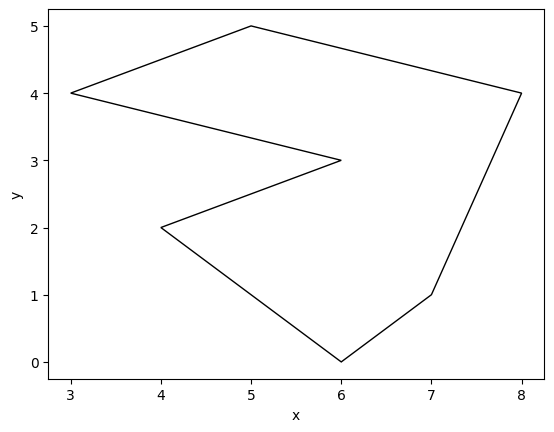

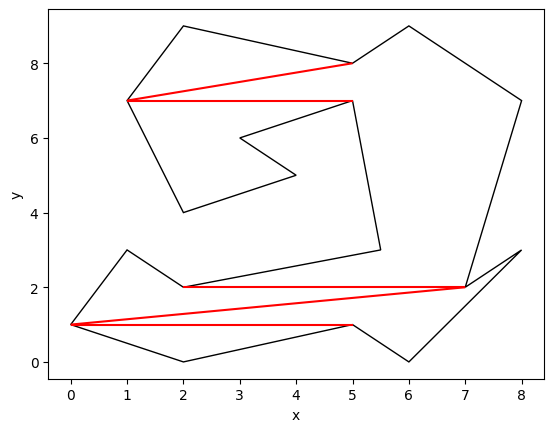

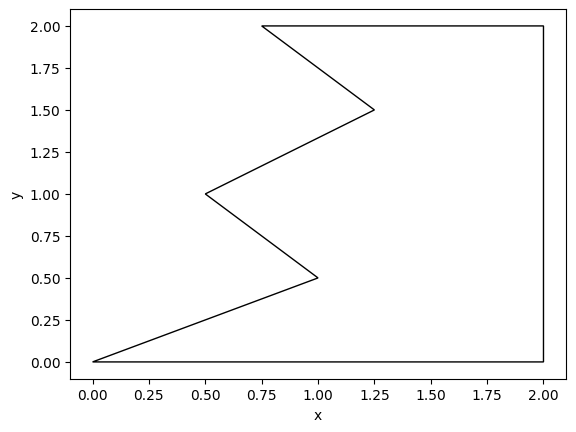

In [25]:
my_tests_polygon = [polygon_example_1, polygon_example_2, polygon]
for pol in my_tests_polygon:
    newDiag = divideToMonotonicPolygons(pol)
    vis = Visualizer()
    vis.add_polygon(pol, fill=False)
    for diag in newDiag:
        diagP = [pol[diag[0]], pol[diag[1]]]
        vis.add_line_segment(diagP, color='red')
    vis.show()

In [26]:
def inPolygon(polygon, isPointOnLeft, p, p1, p2) -> bool:
    det = mat_det(polygon[p], polygon[p1], polygon[p2])
    if isPointOnLeft[p]:
        return det < 0
    else:
        return det > 0

In [27]:
def triangulation(polygon):
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego. 
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki 1-5 i 2-3
    """
    n = len(polygon)
    isPointOnLeft = onLeftSideOfPolygon(polygon)
    pointsOrder = [i for i in range(n)]
    pointsOrder = sorted(
        pointsOrder, key=lambda x: (-polygon[x][1], polygon[x][0]))

    S = pointsOrder[:2]
    diagonals = []
    for p in pointsOrder[2:]:
        if isPointOnLeft[p] != isPointOnLeft[S[-1]]:
            top = S[-1:]
            for v in S:
                # nie dodajemy krawedzi ktore już są dodane
                if v != prevNbour(p, n) and v != nextNbour(p, n):
                    diagonals.append(sorted([p, v]))
            S = top + [p]
        else:
            taken = []
            p2 = S.pop()
            while len(S) > 0:
                p1 = p2
                p2 = S.pop()
                if inPolygon(polygon, isPointOnLeft, p, p1, p2):
                    if p2 != prevNbour(p, n) and p2 != nextNbour(p, n):
                        diagonals.append(sorted([p, p2]))
                else:
                    taken.append(p1)
            S.append(p2)
            S += taken[::-1]
            S.append(p)
    return diagonals
    # res = [tuple(polygon[i] for i in d) for d in diagonals]
    # res = list(filter(lambda x: x not in polygon, res))
    # return res

In [28]:
def triangulation_draw(polygon):
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego. 
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki 1-5 i 2-3
    """
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    n = len(polygon)
    isPointOnLeft = onLeftSideOfPolygon(polygon)
    pointsOrder = [i for i in range(n)]
    pointsOrder = sorted(
        pointsOrder, key=lambda x: (-polygon[x][1], polygon[x][0]))

    S = pointsOrder[:2]
    diagonals = []
    for p in pointsOrder[2:]:
        if isPointOnLeft[p] != isPointOnLeft[S[-1]]:
            top = S[-1:]
            for v in S:
                # nie dodajemy krawedzi ktore już są dodane
                if v != prevNbour(p, n) and v != nextNbour(p, n):
                    diagonals.append(sorted([p, v]))
                    vis.add_line_segment((polygon[p], polygon[v]), color='red')
            S = top + [p]
        else:
            taken = []
            p2 = S.pop()
            while len(S) > 0:
                p1 = p2
                p2 = S.pop()
                if inPolygon(polygon, isPointOnLeft, p, p1, p2):
                    if p2 != prevNbour(p, n) and p2 != nextNbour(p, n):
                        diagonals.append(sorted([p, p2]))
                    vis.add_line_segment(
                        (polygon[p], polygon[p2]), color='red')

                else:
                    taken.append(p1)
            S.append(p2)
            S += taken[::-1]
            S.append(p)
    return diagonals, vis

Jakich struktur można użyć do przechowywania wielokątu, oraz utworzonej triangulacji? Uzasadnij wybór struktury w swoim algorytmie

ODPOWIEDŹ: 

Przeprowadź testy poprawności powyższej funkcji.


In [29]:
Test().runtest(3, triangulation)

Lab 3, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.006s


Zwizualizuj powstały wielokąt podzielony na trójkąty.

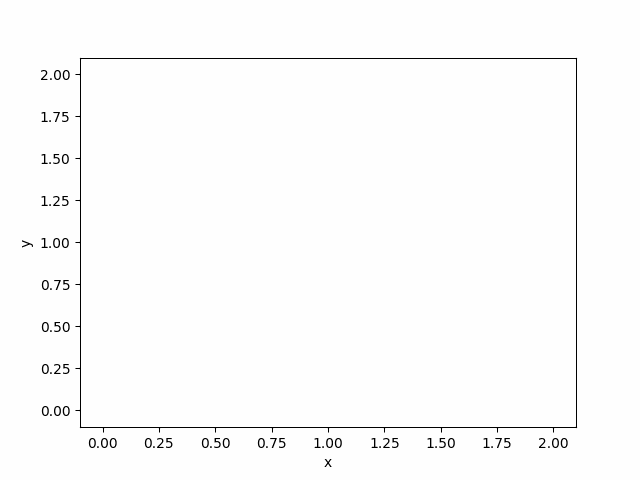

In [30]:
tri, vis = triangulation_draw(polygon)
vis.show_gif(interval=300)